In [201]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

plt.style.use('ggplot')

находим изображения

In [202]:
relative_path = "Data/zn/images/*"

imgs_path = glob(relative_path)

для тестов возьмем 5 адресов

In [203]:
imgs_path = imgs_path[:5]

(раскомм.) изобразить первые 20

In [204]:
# fig, axs = plt.subplots(20, 1, figsize=(50, 100))
# axs = axs.flatten()
# 
# imgs_to_print = len(imgs_path) if len(imgs_path) < 20 else 20
# 
# for i in range(imgs_to_print):
#     axs[i].imshow(plt.imread(imgs_path[i]))
#     axs[i].axis('off')
#     axs[i].set_title(imgs_path[i].split('/')[-1])
# plt.show()

указываем платформу

In [205]:
platforms_dict = {'tg': 0, 'vk': 1, 'yt1': 2, 'yt2': 3, 'zn': 4}

platform = platforms_dict['zn']

print(platform)

4


детектим текст

In [206]:
import easyocr

reader = easyocr.Reader(['ru'], gpu = True)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


(раскомм.) визуально проверить корректность обнаружения

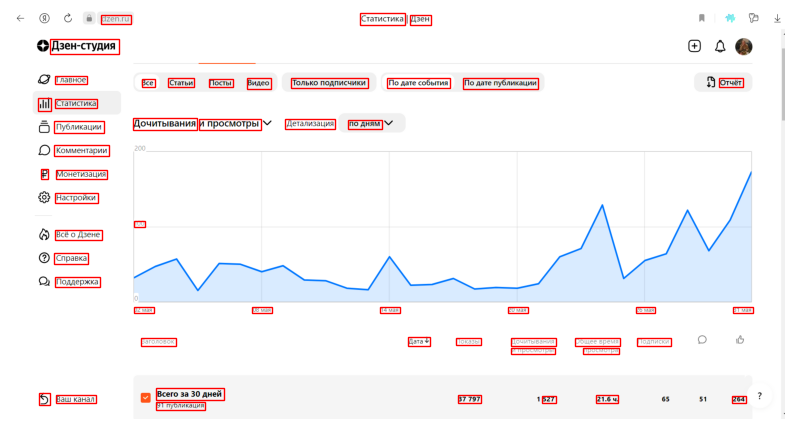

In [220]:
# from matplotlib.patches import Rectangle
# 
# img_path = imgs_path[2]
# 
# detects = reader.detect(img_path)[0][0]
# 
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.imshow(plt.imread(img_path))
# ax.axis('off')
# 
# for i in range(len(detects)):
#     plt.gca().add_patch(Rectangle((detects[i][0],detects[i][2]),
#                                   detects[i][1] - detects[i][0],
#                                   detects[i][3] - detects[i][2],
#                                   edgecolor='red',
#                                   facecolor='none',
#                                   lw= 1 ))
# 
# plt.show()

заведем массив содержащий имя файла и данные об обнаруженном тексте (~15сек/изображение)

In [208]:
imgs_data = pd.DataFrame(columns = ["name", "data"])

for i in range(len(imgs_path)):
    img_path = imgs_path[i]
    img_detect = pd.DataFrame(reader.readtext(img_path), columns=["bbox", "text", "conf"])
    img_name = img_path.split('/')[-1]

    imgs_data.loc[len(imgs_data)] = {"name": img_name, "data": img_detect}

In [209]:
imgs_data['data'][1]

,bbox,text,conf
0,"[[65, 9], [91, 9], [91, 23], [65, 23]]",е;,0.294565
1,"[[119, 9], [145, 9], [145, 23], [119, 23]]",чП<],0.139729
2,"[[175, 9], [201, 9], [201, 23], [175, 23]]",[ге€,0.659551
3,"[[229, 9], [255, 9], [255, 23], [229, 23]]",Уст,0.902424
4,"[[285, 9], [311, 9], [311, 23], [285, 23]]",Нов,0.589968
...,...,...,...
71,"[[1061, 815], [1085, 815], [1085, 827], [1061,...",636,0.999998
72,"[[1317, 815], [1341, 815], [1341, 827], [1317,...",101,0.999989
73,"[[1379, 813], [1403, 813], [1403, 827], [1379,...",783,0.999907
74,"[[243, 821], [315, 821], [315, 835], [243, 835]]",Ваш канал,0.997903


в зависимости от выбранной платформы выбираем функцию для обработки

вспомогательные функции

In [210]:
def find_strings_with_percent(strings):
    result = []

    for s in strings:
        if "%" in s:
            result.append(s)

    return result

import math
def find_rectangle_center(vertices):
    x_sum = 0
    y_sum = 0
    num_vertices = len(vertices)

    for vertex in vertices:
        x_sum += vertex[0]
        y_sum += vertex[1]

    x_center = x_sum / num_vertices
    y_center = y_sum / num_vertices

    return x_center, y_center

def is_digit(string):
    if string.isdigit():
        return True
    else:
        try:
            float(string)
            return True
        except ValueError:
            return False

def get_num_strings(df):
    num_strings = []
    for t_line in df:
        if is_digit(t_line):
            num_strings.append(t_line)
    return num_strings

tg

In [211]:
# Нахождение названия метрики на скрине
def get_metric_name_coord_tg(df):
    # Выбираем строки где есть название метрик и достаем ячейку с координатами
    t_line = df.loc[df['text'] == 'VR']['bbox']
    # print(t_line.empty)
    if t_line.empty:
        print('VR не найден')
        t_line = df.loc[df['text'] == 'ERR']['bbox']
        if t_line.empty:
            print('ERR не найден')
            t_line = df.loc[df['text'] == 'ER']['bbox']
            if t_line.empty:
                print('ER не найден')
                return
    # print(t_line)
    # Получаем список координат названия
    t_coord = t_line.values[0]
    # print(t_coord)
    return t_coord


def get_metric_from_tg(df):
    # Нахождение название метрики на скрине
    t_coord = get_metric_name_coord_tg(df)

    # Теперь, чтобы понять какое из значений - наша метрика, будем находить центры прямоугольников с текстом
    # и наименьшее расстояние между названием метрики и строк с процентами

    centr_text_x, centr_text_y = find_rectangle_center(t_coord)

    distance_list = []
    text_list = []

    strings_with_percent = find_strings_with_percent(df['text'])

    for metric_text in strings_with_percent:
        metric_coord = df.loc[df['text'] == metric_text]['bbox'].values[0]
        print(metric_coord)
        center_x, center_y = find_rectangle_center(metric_coord)
        distance = math.sqrt((centr_text_x - center_x)**2 + (centr_text_y - center_y)**2)
        distance_list.append(distance)
        text_list.append(metric_text)
    # костыль одинаковые именна всегда ссылаются на один объект!
    print(distance_list)

    # Находим индекc минимального расстояния и с помощью него ищем нашу метрику
    index = distance_list.index(min(distance_list))
    print(index)
    print('VR =', text_list[index])
    return text_list[index]

zn

In [212]:
def get_metric_name_coord_zn(df):
    # Выбираем строки где есть название метрик и достаем ячейку с координатами
    t_line = df.loc[df['text'] == 'Дочитывания']['bbox']
    # print(t_line.empty)
    if t_line.empty:
        print('Метрика не найдена')
        return
    # print(t_line)
    # Получаем список координат названия
    t_coord = t_line.values[0]
    # print(t_coord)
    return t_coord

def get_metric_from_zn(df):
    # Нахождение название метрики на скрине
    t_coord = get_metric_name_coord_zn(df)

    # Теперь, чтобы понять какое из значений - наша метрика, будем находить центры прямоугольников с текстом
    # и наименьшее расстояние между названием метрики и строк с процентами

    centr_text_x, centr_text_y = find_rectangle_center(t_coord)

    distance_list = []
    text_list = []
    num_strings = get_num_strings(df['text'])

    for metric_text in num_strings:
        metric_coord = df.loc[df['text'] == metric_text]['bbox'].values[0]
        print(metric_coord)
        center_x, center_y = find_rectangle_center(metric_coord)
        distance = math.sqrt((centr_text_x - center_x)**2 + (centr_text_y - center_y)**2)
        distance_list.append(distance)
        text_list.append(metric_text)
    # костыль одинаковые именна всегда ссылаются на один объект!
    print(distance_list)

    # Находим индекc минимального расстояния и с помощью него ищем нашу метрику
    index = distance_list.index(min(distance_list))
    print(index)
    print('VR =', text_list[index])
    return text_list[index]


yt просмотры

In [213]:
def get_metric_name_coord_yt1(df):
    # Выбираем строки где есть название метрик и достаем ячейку с координатами
    t_line = df.loc[df['text'] == 'Просмотры']['bbox']
    # print(t_line.empty)
    if t_line.empty:
        print('Метрика не найдена')
        return
    # print(t_line)
    # Получаем список координат названия
    t_coord = t_line.values[0]
    # print(t_coord)
    return t_coord

def get_matching_str_yt1(df):
    import re
    pattern = r"[1-9]*,*[1-9][ ]*(млн|тыс.)*"
    str_l = df['text']
    matching_strings = [s for s in str_l if re.match(pattern, s)]
    print(matching_strings)
    return matching_strings

def get_metric_from_yt1(df):
    # Нахождение название метрики на скрине
    t_coord = get_metric_name_coord_yt1(df)

    # Теперь, чтобы понять какое из значений - наша метрика, будем находить центры прямоугольников с текстом
    # и наименьшее расстояние между названием метрики и строк с процентами

    centr_text_x, centr_text_y = find_rectangle_center(t_coord)
    matching_strings = get_matching_str_yt1(df)
    distance_list = []
    text_list = []

    for metric_text in matching_strings:
        metric_coord = df.loc[df['text'] == metric_text]['bbox'].values[0]
        print(metric_coord)
        center_x, center_y = find_rectangle_center(metric_coord)
        distance = math.sqrt((centr_text_x - center_x)**2 + (centr_text_y - center_y)**2)
        distance_list.append(distance)
        text_list.append(metric_text)
    # костыль одинаковые именна всегда ссылаются на один объект!
    print(distance_list)

    # Находим индекc минимального расстояния и с помощью него ищем нашу метрику
    index = distance_list.index(min(distance_list))
    print(index)
    print('VR =', text_list[index])
    return text_list[index]

yt подпищеки

In [214]:
def get_metric_name_list_yt2(df):
    import re
    pattern = r"(.)*[Пп]одписчик[аи]?(ов)?"
    str_l = df['text']
    matching_strings = [s for s in str_l if re.match(pattern, s)]
    return matching_strings

def get_metric_from_yt2(df):
    metric_text = get_metric_name_list_yt2(df)

    metric_coord = df.loc[df['text'] == metric_text[0]]['bbox'].values[0]

    center_text_x, center_text_y = find_rectangle_center(metric_coord)

    num_strings = get_num_strings(df['text'])

    distance_list = []
    text_list = []

    for metric_text in num_strings:
        metric_coord = df.loc[df['text'] == metric_text]['bbox'].values[0]
        # print(metric_coord)
        center_x, center_y = find_rectangle_center(metric_coord)
        distance = math.sqrt((center_text_x - center_x)**2 + (center_text_y - center_y)**2)
        distance_list.append(distance)
        text_list.append(metric_text)

    print(distance_list)

    # Находим индекc минимального расстояния и с помощью него ищем нашу метрику
    index = distance_list.index(min(distance_list))
    print('VR =', text_list[index])
    return text_list[index]


vk

In [221]:
def sum(data:dict) -> int:
    sum = 0
    for i in data.keys():
        sum+= data[i]
    return sum

def find(df, bbox:list) -> list:
    """
    Расширяем область поиска
    """
    bboxes = df.bbox.tolist()
    text = df.text.tolist()
    for i in range(len(bboxes)):

        if (-30 < bbox[0][0] - bboxes[i][0][0] < 40) and  (0 < bbox[0][1]-bboxes[i][0][1] < 100) and text[i].isdigit():
            print(bbox[0][0] - bboxes[i][0][0])
            return int(text[i])
    else:
        return None

def convert_to_dict(string: str) -> None:
    out = string.split()
    if len(out) == 2:
        try:
            out = {out[1]: int(out[0])}
            return out
        except:
            pass

        try:
            out = {out[0]: int(out[1])}
            return out
        except:
            return None

def get_data_vk(df, img_path):
    use_to = pd.DataFrame(df['text'].str.lower())
    use_to['bbox'] = df['bbox']
    use_to = use_to.loc[use_to['text'].str.contains(REGEXP)]
    tmp = use_to['text'].tolist()
    bboxes = use_to['bbox'].tolist()
    out = {}

    for i in range(len(tmp)):
        g = convert_to_dict(tmp[i])
        if g:
            out.update(g)
        else:
            check = find(df, bboxes[i])
            if check:
                out.update({tmp[i]:check})

    return sum(out)

в зависимости от выбранной платформы будем использовать подходящую функцию

In [225]:
result = pd.DataFrame(columns=["name", "target"])

if platform == platforms_dict['tg']:
    func_processing = get_metric_from_tg
elif platform == platforms_dict['vk']:
    func_processing = get_data_vk
elif platform == platforms_dict['yt1']:
    func_processing = get_metric_from_yt1
elif platform == platforms_dict['yt2']:
    func_processing = get_metric_from_yt2
elif platform == platforms_dict['zn']:
    func_processing = get_metric_from_zn

обрабатываем все данные 

In [226]:
for i in range(len(imgs_data)):
    print(i)
    result.loc[len(result)] = {'name': imgs_data['name'][i], 'target': func_processing(imgs_data.loc[i]['data'])}

# imgs_data.loc[2]['data']
result

0
[[225, 327], [251, 327], [251, 343], [225, 343]]
[[923, 851], [953, 851], [953, 869], [923, 869]]
[[1079, 851], [1109, 851], [1109, 869], [1079, 869]]
[[1407, 851], [1429, 851], [1429, 869], [1407, 869]]
[[1479, 853], [1509, 853], [1509, 869], [1479, 869]]
[[24, 878], [50, 878], [50, 908], [24, 908]]
[918.1508590640211, 172.55723688098394, 124.1933975700802, 375.68071550187403, 448.6256791580259, 1036.3561164001494]
2
VR = 135
1
[[507, 9], [533, 9], [533, 25], [507, 25]]
[[375, 393], [397, 393], [397, 405], [375, 405]]
[[1061, 815], [1085, 815], [1085, 827], [1061, 827]]
[[1317, 815], [1341, 815], [1341, 827], [1317, 827]]
[[1379, 813], [1403, 813], [1403, 827], [1379, 827]]
[880.8178018182875, 734.3296262578543, 100.2845950283492, 300.7341018241862, 359.76937056953585]
2
VR = 636
2
[[289, 493], [315, 493], [315, 507], [289, 507]]
[[66, 894], [92, 894], [92, 924], [66, 924]]
[[1241, 903], [1273, 903], [1273, 919], [1241, 919]]
[[1685, 903], [1717, 903], [1717, 919], [1685, 919]]
[239

,name,target
0,bbb2ec82-ab95-42f9-be90-58c0e35c653c.png,135
1,8a7a366c-ae97-45ad-87c4-0f6487b8e9ba.png,636
2,74f4b236-c1a7-45a6-b11a-2d5ab5325db3.png,100
3,3e9053a6-c5c3-4b21-815a-fb7fdf758150.png,375
4,0578d9d6-0353-4a1c-9fad-91e1f2d9864e.png,293


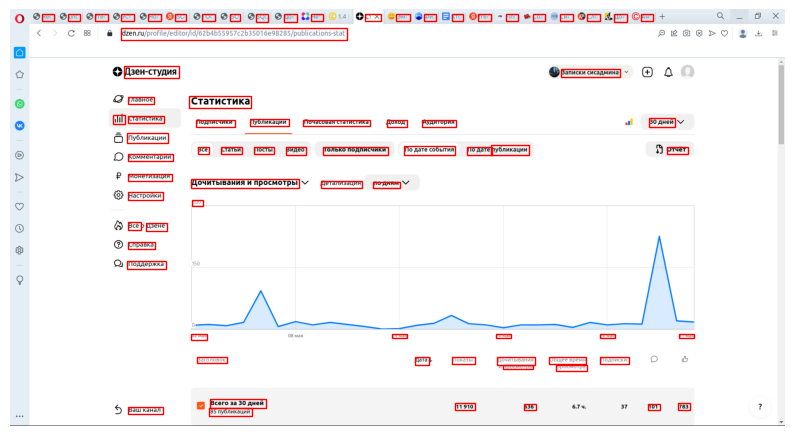

In [227]:
from matplotlib.patches import Rectangle

img_path = imgs_path[1]

detects = reader.detect(img_path)[0][0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(img_path))
ax.axis('off')

for i in range(len(detects)):
    plt.gca().add_patch(Rectangle((detects[i][0],detects[i][2]),
                                  detects[i][1] - detects[i][0],
                                  detects[i][3] - detects[i][2],
                                  edgecolor='red',
                                  facecolor='none',
                                  lw= 1 ))

plt.show()